<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Fractional and Volterra processes in Finance  </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Challenge 2 -  Pricing by Fourier </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> Challenge : Unlock the potential of Gaussian fractional processes and pave the way for more accurate simulations! </strong></p>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>

- Joseph LECLERE
- Constantin GLEYZE
- Williams DJAFRI

<font color='red'>**DEADLINE: 23 February before 10 AM to be sent by email to eduardo.abi-jaber@polytechnique.edu**</font>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p>

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


Calls are obtained by Put call parity (r=0).


To sanity check your code here are two value of references for prices of call.

Recall:



<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">
    <strong>Theorem</strong>. (Characteristic function in Heston model)  For a real number v,
$$
\mathbb E[\exp\left(iv\log S_T \right) |\mathcal F_t]  = \exp\left( iv\log S_t + \phi(T-t)  + \psi(T-t) V_t \right),
$$
with
\begin{align*}
\psi(t)&= \frac{\beta(v)-D(v)}{\eta^2}\frac{1-e^{-D(v)t}}{1-G(v)e^{-D(v)t}}\\
\phi(t)&= \frac{\theta}{\eta^2}\left((\beta(v)-D(v))t - 2 \log\left( \frac{G(v)e^{-D(v)t}-1}{G(v)-1} \right)\right)  \\
\beta(v) &= \kappa - iv \rho\eta, \quad  D(v)= \sqrt{\beta(v)^2  + \eta^2 v(i+v)}, \quad G(v) =\frac{\beta(v)-D(v)}{\beta(v)+ D(v)}.
\end{align*}
</div>
   

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

**We will compute this expectation using the therom above conditionnaly to $\mathcal F_0$.**

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import quad,IntegrationWarning
from scipy.optimize import brentq
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from numpy.polynomial.laguerre import laggauss
from scipy.optimize import minimize
from py_vollib.black_scholes.implied_volatility import implied_volatility
from scipy.special import roots_legendre
import warnings
warnings.filterwarnings("ignore", category=IntegrationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

$\textbf{Question 1.1:}$


In [2]:
#We define as given the Heston Characterictic functions
def Heston_Charac_function(theta, eta,kappa,rho, S0,V0, T,z):
    Beta = kappa -1j*z*rho*eta
    D = np.sqrt(Beta**2 + (eta**2)*z*(1j+z))
    G = (Beta - D)/(Beta + D)
    psi = ((Beta - D)/(eta**2)) * ((1 - np.exp(-D*T))/(1 - G*np.exp(-D*T)))
    phi = (theta/(eta**2))*((Beta - D)*T - 2*np.log((G*np.exp(-D*T) - 1)/(G -1)))
    return np.exp(1j*z*np.log(S0) + phi + psi*V0)

$\textbf{Question 1.2:}$


In [3]:
#We implement the put price with Heston as given above
def Heston_put_price (theta, eta,kappa,rho, S0,V0, T,K):

    def integrale(z):
        return np.real(np.exp(1j*z*(np.log(S0/K)))*(Heston_Charac_function(theta, eta,kappa,rho, S0,V0, T,z -(1j/2))/((z**2)+0.25)))

    #We use quad to approximate the integral
    result,_ = quad(integrale, 0, np.inf, limit = 200)

    return K - (np.sqrt(S0*K)/np.pi)*result

#Because the hypothesis of the absence of arbitrage opportunity still holds within the Heston model
#We can use the Call-Put parity to compute directly the price of the call
def Heston_call_price(theta, eta,kappa,rho, S0,V0, T,K):
    return Heston_put_price (theta, eta,kappa,rho, S0,V0, T,K)  + S0 - K*np.exp(-r*T)

In [4]:
kappa = 1.5768
theta = 0.0398*1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
T1=1
T10=10
eta=sigma
r=0.2
K = 1.
S0 = 1.

ref_value_T1y = 0.05785155435
ref_value_T10y = 0.22318945791474590
Heston_price_1 = Heston_put_price(theta, eta,kappa,rho, S0,V0, T1,K)
Heston_price_10 = Heston_put_price(theta, eta,kappa,rho, S0,V0, T10,K)

print(f"Heston price : {Heston_price_1}")
print(f"Real price : {ref_value_T1y}")
print(f"Match with the looked value at 10^(-10) : {np.abs(Heston_price_1 - ref_value_T1y)<=10**(-10)}")

print(f"\nHeston price : {Heston_price_10}")
print(f"Real price : {ref_value_T10y}")
print(f"Match with the looked value at 10^(-10) : {np.abs(Heston_price_10 - ref_value_T10y)<=10**(-10)}")

Heston price : 0.057851554343202105
Real price : 0.05785155435
Match with the looked value at 10^(-10) : True

Heston price : 0.2231894579115471
Real price : 0.2231894579147459
Match with the looked value at 10^(-10) : True


$\textbf{Question 1.3:}$


In [5]:
#We will need the BS price to compute our implied vol - they will be supposed to be the market price of the option
def BS_call_price(S0, sigma, T, K, r=0):
    sigma = np.where(sigma > 1e-8, sigma, 1e-8)
    d1 = (np.log(S0/(K*np.exp(-r*T))) + (sigma**2)*(T/2))/(sigma*np.sqrt(T)).astype(np.float32)
    d2 = d1 - sigma*np.sqrt(T).astype(np.float32)
    call_price= S0*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return call_price

#We use the put-call parity
def BS_put_price(S0, sigma, T, K, r=0):
    return BS_call_price (S0, sigma, T, K, r)  - S0 + K*np.exp(-r*T)

In [45]:
#Function to compute our implied volatility
#We make it general to compute several implied vol for several strike and maturity
def implied_vol(BS_price, Heston_price, theta, eta,kappa,rho, V0,S0,r=0,T=1,K=1) :

    #The function we will seek to optimize
    def objective (sigma, K, T):
        return BS_price(S0, sigma, T, K, r) - Heston_price (theta, eta,kappa,rho, S0,V0, T,K)

    #Convert in np.array if it is a scalar because of the chosen generality of our code
    K = np.array([K]) if np.isscalar(K) else np.array(K)
    T = np.array([T]) if np.isscalar(T) else np.array(T)

    #The matrix that will stock our computed implied vol
    sigma_init = np.empty((len(K), len(T)))

    for idx_K, K1 in enumerate(K):
        for idx_T,T1 in enumerate(T):

            #Because for certain value of T and K the function does not change in sign, we manage this case by putting nan value
            try :
                f_min = objective(1e-6, K1, T1)
                f_max = objective(3.0, K1, T1)

                if f_min * f_max < 0:
                    sigma_init[idx_K, idx_T] = brentq(objective, 1e-6, 1.0,rtol=1e-15, maxiter=200, args=(K1, T1))
                else:
                    sigma_init[idx_K, idx_T] = np.nan
            except ValueError:
                sigma_init[idx_K, idx_T] = np.nan

    #To be able to have a visuable plot, we extrapolate the nan point according to their neighbors
    sigma_init = np.nan_to_num(sigma_init, nan=np.nanmean(sigma_init))

    #Technicality to manage the single or multi requests done
    if len(K) == 1 and len(T) == 1:
        sigma_init = sigma_init[0, 0]
    elif len(K) == 1:
        sigma_init = sigma_init.flatten()
    elif len(T) == 1:
        sigma_init = sigma_init[:, 0]

    return sigma_init

#Function to plot the implied vol according to the given parameters T and K
def plot_implied_vol(T, K, sigma):
    K = np.array([K]) if np.isscalar(K) else np.array(K)
    T = np.array([T]) if np.isscalar(T) else np.array(T)

    if len(K) == 1 and len(T) == 1:
        return f"The implied volatility is {sigma}"

    elif len(K) == 1:
        plt.plot(T, sigma, label=r'$\sigma_{\text{impl}}$')
        plt.xlabel("T")
        plt.ylabel("Implied volatility")
        plt.title(r"$\sigma_{\text{impl}}$" + f" for K = {K[0]}")
        plt.legend()
        plt.show()

    elif len(K) != 1 and len(T) == 1:
        plt.plot(K, sigma, label=r'$\sigma_{\text{impl}}$')
        plt.xlabel("K")
        plt.ylabel("Implied volatility")
        plt.title(r"$\sigma_{\text{impl}}$" + f" for T = {T[0]}")
        plt.legend()
        plt.show()
    else:
        T_mesh, K_mesh = np.meshgrid(T, K, indexing='ij')
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(T_mesh, K_mesh, sigma, cmap="viridis", alpha=0.8)  
        ax.set_xlabel("T")
        ax.set_ylabel("K")
        ax.set_title(r'$\sigma_{\text{impl}}$')
        cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
        cbar.set_label(r'$\sigma_{\text{impl}}$', rotation=270, labelpad=15)

        plt.show()

We do a first plot to see for a medium maturity as it may explode for short maturity and therefore not enable to see the variations for T = 1.

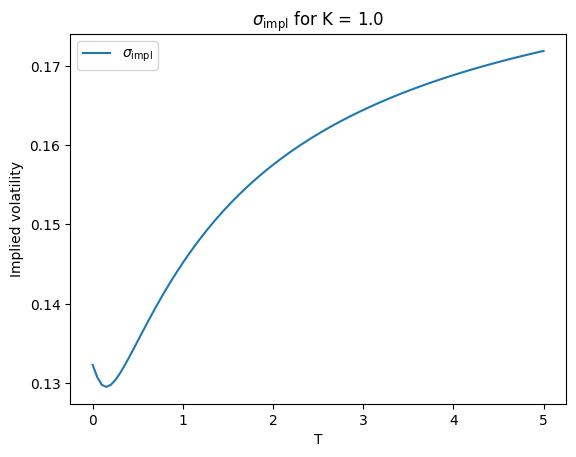

In [43]:
kappa = 1.5768
theta = 0.0398*1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
T = np.linspace(0.001, 5, 100)  
eta=sigma
r=0.
K = np.array([1.])
S0 = 1.

plot_implied_vol(T,K,implied_vol (BS_call_price, Heston_call_price, theta, eta,kappa,rho, V0,S0,r,T,K))

We now plot for several strikes and maturities.


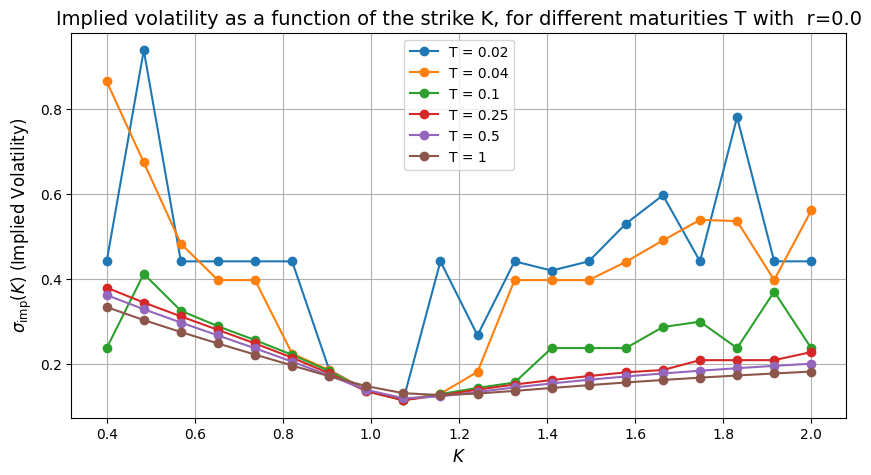

In [39]:
kappa = 1.5768
theta = 0.0398*1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
maturities = [0.02, 0.04, 0.1, 0.25, 0.5, 1]
# maturities = [0.02,0.1]
eta=sigma
r=0.
strikes = np.linspace(0.4, 2, 20)
# strikes = np.linspace(0.4, 2, 2)

S0 = 1.

plt.figure(figsize=(10, 5))

for T in maturities:
    implied_vols = implied_vol(BS_call_price, Heston_call_price, theta, eta, kappa, rho, V0, S0, r, T, strikes) 
    plt.plot(strikes, implied_vols, marker='o', label=f"T = {T}")  # Tracé

plt.xlabel(r"$K$", fontsize=12)
plt.ylabel(r"$\sigma_{\text{imp}}(K)$ (Implied Volatility)", fontsize=12)
plt.title(f"Implied volatility as a function of the strike K, for different maturities T with  r={r}", fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

After several tests and because for certains maturities we can have only nan values (making an interpolation complex or obliging us to put a fixed default value), we decided to put the average when nan. 

Because we have more nan for small T, we therefore have less smooth representation, due to the construction. 

We now plot our nap of volatility according to maturity and strike. 

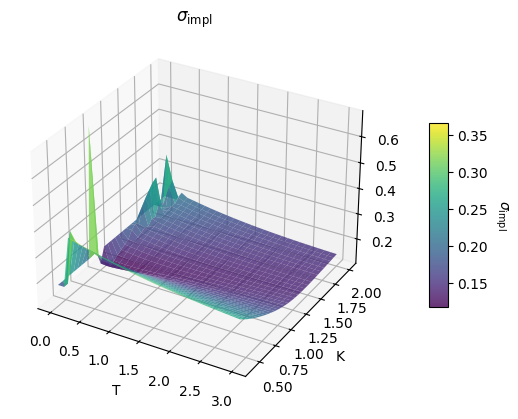

In [48]:
#We plot the implied nap of volatility for T and K changing
kappa = 1.5768
theta = 0.0398*1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
maturities = np.linspace(0.001,3,30)
eta=sigma
r=0.
strikes = np.linspace(0.4, 2, 30)
S0 = 1.

plot_implied_vol(maturities,strikes,implied_vol (BS_call_price, Heston_call_price, theta, eta,kappa,rho, V0,S0,r,maturities,strikes))

$\textbf{Question 1.4:}$


We remember the formula of the skew :

$\text{Skew} = \frac{\partial \sigma_{\text{impl}}}{\partial K}$

Which can be approximate by :

$\text{Skew} \approx \frac{\sigma_{\text{impl}}(K+\Delta K) - \sigma_{\text{impl}}(K-\Delta K)}{2\Delta K}$


In [49]:
#We define our function to compute the skew
def ATM_skew (BS_price, Heston_price, theta,rho, V0,S0,r,T,K, epsilon):
    epsilon = np.array([epsilon]) if np.isscalar(epsilon) else np.array(epsilon)
    skews = []
    for idx_eps, eps in enumerate(epsilon) :
        eta = (1/eps)
        kappa  = (1 / eps)

        #The additional lenght used to compute the derivative
        delta_K = K*(1e-4)

        #We do not need to manage the NaN value as it is already managed within the function implied_vol
        vol_K_high = implied_vol (BS_price, Heston_price, theta, eta,kappa,rho, V0,S0,r,T,K+delta_K)
        vol_K_low = implied_vol (BS_price, Heston_price, theta, eta,kappa,rho, V0,S0,r,T,K-delta_K)
        results = (vol_K_high - vol_K_low)/(2*delta_K)
        skews.append(results)
    return skews

We first want to evaluate the impact of the risk free interest rate of the ATM skew to make a good choice to plot the ATM skew with $\epsilon \to 0$.

We do with T goes until 5 years to also confirm our function for the ATM works well. 

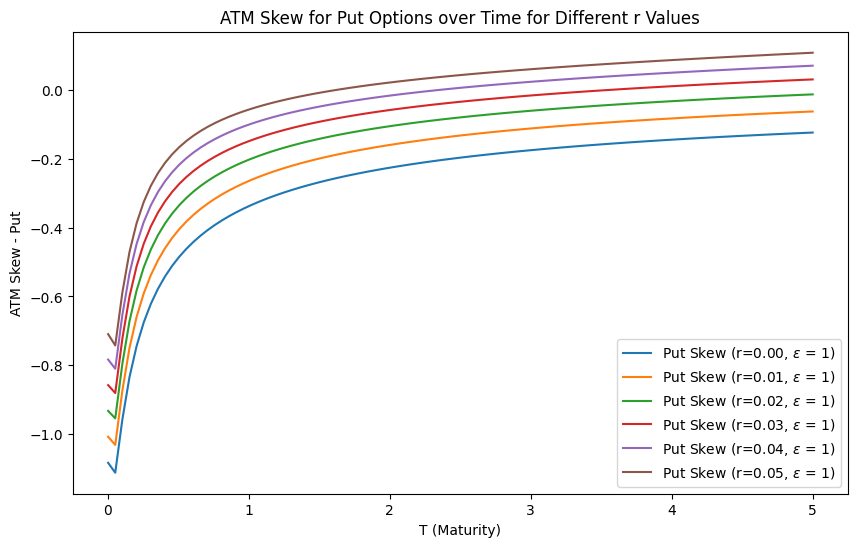

In [51]:
theta = 0.0398 * 1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
S0 = 1.
K = S0

T = np.linspace(0.001, 5, 100)  
r_values = np.arange(0, 0.06, 0.01)
epsilon = 1  

fig, ax = plt.subplots(figsize=(10, 6))

for r in r_values:
    atm_skew_put = ATM_skew(BS_put_price, Heston_put_price, theta, rho, V0, S0, r, T, K, epsilon)
    ax.plot(T, atm_skew_put[0], label=f'Put Skew (r={r:.2f}, $\epsilon$ = {epsilon})')

ax.set_xlabel("T (Maturity)")
ax.set_ylabel("ATM Skew - Put")
ax.set_title("ATM Skew for Put Options over Time for Different r Values")
plt.grid(False)
ax.legend()
plt.show()

Having this biais undiced by the choice of the risk free interest rate , we take r=0 to plot the value with the epsilon

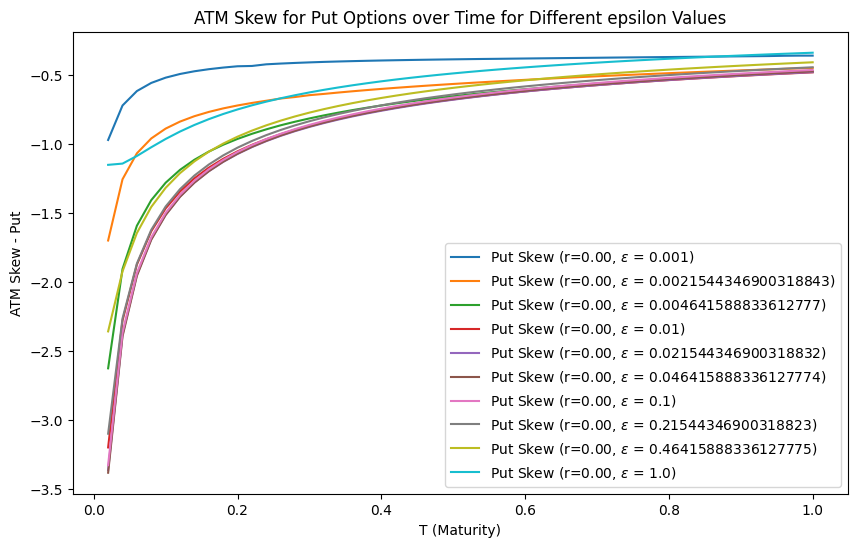

In [53]:
theta = 0.0398 * 1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751
S0 = 1.
T = np.linspace(0.02,1,50)
r = 0.
epsilon_values = np.logspace(-3, 0, 10)
K = S0

fig, ax = plt.subplots(figsize=(10, 6))

for epsilon in epsilon_values:
    atm_skew_put = ATM_skew(BS_put_price, Heston_put_price, theta, rho, V0, S0, r, T, K, epsilon)
    ax.plot(T, atm_skew_put[0], label=f'Put Skew (r={r:.2f}, $\epsilon$ = {epsilon})')

ax.set_xlabel("T (Maturity)")
ax.set_ylabel("ATM Skew - Put")
ax.set_title("ATM Skew for Put Options over Time for Different epsilon Values")
plt.grid(False)
ax.legend()
plt.show()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Volterra Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong>  </strong></p>

1. Do the same thing for Volterra Heston model:
Heston by a fractional one:
\begin{align*}
	dS_t &= S_t \sqrt{V_t} dB_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}(t-s) \left(  ( \theta - \lambda V_s) ds +  \eta  \sqrt{V_s} dW_s \right),
\end{align*}
with $K_{\epsilon}(t) = {{(t +\epsilon)}^{H-1/2}}$

by implementing the Adam Scheme (or any other scheme) for the Riccati Volterra equation

2.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters
$$
 \lambda = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1.
$$
3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment
4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment.
5. Which model seems more suited for the market? argue.


Volterra Riccati equation:

$\psi(t) = \int_{0}^{t} K(t-s) F(\psi(s)) ds$

$F(\psi) = (u^{2} - u)/2 + (u \rho \eta - \lambda) \psi + \psi^{2} \eta^{2} / 2$




$\textbf{Question 2.1:}$

We reproduced the first section in 3 steps.

$\textbf{Step 1: Solving the Riccati equation}$

We implemented a two-step adam scheme using the trapeze rule as discretisation for the integral:

- First, $\psi(t_{n}) = dt \times K(dt) \times F(\psi(t_{n-1})) + \int_{0}^{t_{n-1}} K(t_{n} - s) F(\psi(s)) ds$ with the second integral approximated with trapeze rule.

- Then, $\psi(t_{n}) = \int_{0}^{t_{n}} K(t_{n} - s) F(\psi(s)) ds$ where we use the trapeze rule on the whole integral with the value of $\psi(t_{n})$ first approximated above.

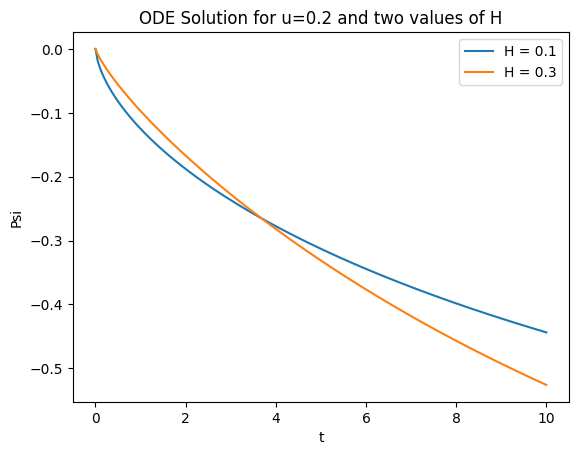

In [46]:
def kernel(t, s, H = 0.1, eps = 0.01):
  return (t - s + eps)**(H - 1/2)

def F(psi, u, rho, eta, lambd=0):
  psi = np.clip(psi, -1e4, 1e4)
  return np.clip(0.5 * (u*(u - 1 + rho * eta * psi)) - lambd * psi + (eta**2 / 2) * psi**2, -1e4, 1e4)

def solve_volterra_vect(T, N, H = 0.1, eps = 0.01, u=np.array([0.2]), rho=-0.7, eta=0.3, lambd=0):
  times = np.linspace(0, T, N)
  if isinstance(u, np.ndarray):
    psi = np.zeros((N, len(u)), dtype=complex)
  else:
    psi = np.zeros((N,1), dtype=complex)
  for i in range(1, N):
    integral = np.trapz(np.array([kernel(times[i], times[j], H = H, eps = eps) * F(psi[j], u, rho, eta, lambd) for j in range(i)]).T, times[:i]) + (times[i]-times[i-1]) * kernel(times[i], times[i-1], H=H, eps=eps) * F(psi[i-1], u, rho, eta, lambd)
    psi[i] = integral
    sol = np.trapz(np.array([kernel(times[i], times[j], H = H, eps = eps) * F(psi[j], u, rho, eta, lambd) for j in range(i+1)]).T, times[:i+1])
    psi[i] = sol
  return times, psi

# test
T, N = 10, 200
times, psi_12 = solve_volterra_vect(T, N, 0.1)
plt.plot(times, psi_12, label="H = 0.1")
times, psi_22 = solve_volterra_vect(T, N, 0.3)
plt.plot(times, psi_22, label="H = 0.3")
plt.xlabel("t")
plt.ylabel("Psi")
plt.title("ODE Solution for u=0.2 and two values of H")
plt.legend()
plt.show()

$\textbf{Step 2: Computing the characteristic function}$

We can compute in closed form the markovian variables $g_{0}$ here, as: $g_{0}(t) = V_{0} + \int_{0}^{t} (t-s+\epsilon)^{H-1/2}ds = V_{0} + \frac{1}{H+1/2}((t+ϵ)^{H+1/2} - \epsilon^{H+1/2})$.

In the Volterra-Heston model, we have access to an analytic form of the characteristic function with the function $\Psi$ solving the Ricatti-Volterra equation as: $$\mathbb{E}[e^{u log(S_{T})}|\mathcal{F}_{0}] = e^{u log(S_{0}) + \int_{0}^{T} g_{0}(t) F(\Psi)(T-t) dt}$$
We implement this by using the Adams scheme approximation of $\Psi$ we did earlier and then using to approximate this integral with trapeze rule again.

In [5]:
def g(times, v0=0.02, H=0.1, lmd=0, theta=0.02, eps=0.01):
  return v0 + ((times + eps)**(H+1/2) - eps**(H+1/2)) * lmd * theta / (H + 1/2)

In [6]:
def characteristic_function_volterra_heston_vect(u, T, H = 0.1, eps = 0.01, s0=1, rho=-0.7, eta=0.3, lmd=0, v0=0.02, theta=0.02):
  times, psi = solve_volterra_vect(T, 400, H, eps, u, rho, eta, lmd)
  values = g(times, v0, H, lmd, theta, eps)
  return np.exp(u * np.log(s0) + np.trapz(np.array([F(psi[j], u, rho, eta, lmd) * values[j] for j in range(len(times))]).T, times))

$\textbf{Step 3: Computing Put option prices with Fourier using Lewis formula}$

We have computed the characteristic formula defined as $\mathbb{E}[e^{u log(S_{T})}]$ and in order to match the definition used above for the Lewis formula, we adapt it to our function by changing their $\phi_{T}(-)$ into $\phi_{T}(j*-)$.

With $k=\log(S_0/K)$,
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(zj+\frac{1}{2})}{z^2 + \frac 1 4 }\right) dz,$$

In [8]:
def func_vec(z, K, T, H = 0.1, eps = 0.01, s0=1):
  return np.real(np.exp(np.clip(z * np.log(s0/K) * 1j, -100, 100)) * characteristic_function_volterra_heston_vect(1/2 + z * 1j, T, H, eps) / (z**2 + 0.25))

def integrate_gl_split(K, T, H=0.1, eps=0.01, s0=1, N=350):
    x, w = roots_legendre(N)
    intervals = [(0.0001, 1), (1, 10), (10, 100)]
    total = 0
    
    for a, b in intervals:
        points = 0.5 * (b-a) * (x + 1) + a
        weights = w * 0.5 * (b-a)
        values = func_vec(points, K, T, H, eps, s0)
        total += np.sum(weights * values)
    
    return total

def put(K, T, H=0.1, eps=0.01, s0=1):
    N = 300
    total = integrate_gl_split(K, T, H, eps, s0, N)
    return (K - (1/np.pi) * (s0 * K)**(1/2) * total)


We compute the price of the put at strike 1 and maturity 1 as reference as well as the associated implied volatility:

In [43]:
put(1, 1)

0.04042328335693479

In [45]:
implied_volatility(0.04042328335693479, 1, 1, 1, 0, 'p')

0.10136953042827235

$\textbf{Question 2.2:}$

We now use the set parameters for the model, and to each put price computed we get the associated implied volatility in the Black-Scholes model.

In [10]:
Maturity = [0.02, 0.04, 0.1, 0.25, 0.5, 1]
strikes = np.linspace(0.4, 2, 20)
volatilities = []
for T in Maturity:
  volatilities.append([implied_volatility(put(strike, T), 1, strike, T, 0, 'p') for strike in strikes])

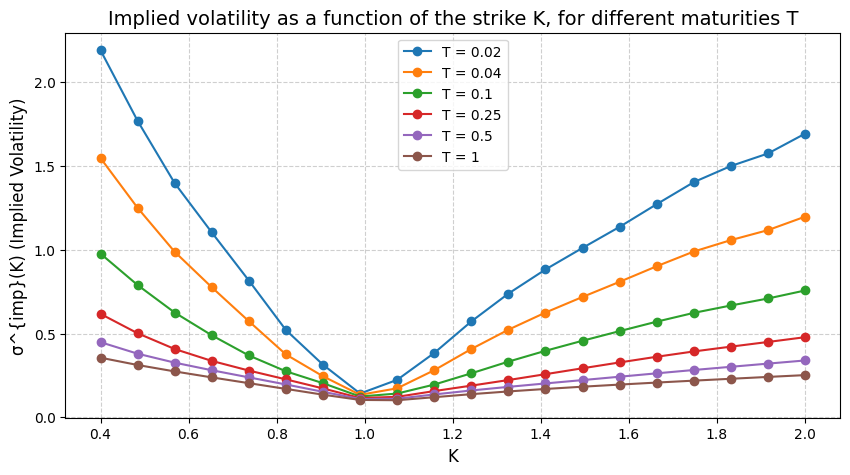

In [36]:
plt.figure(figsize=(10, 5))

for i, t in enumerate(Maturity):
    plt.plot(strikes, volatilities[i], label=f"T = {t}", marker="o", linestyle="-")

plt.title("Implied volatility as a function of the strike K, for different maturities T", fontsize=14)
plt.xlabel("K", fontsize=12)
plt.ylabel("σ^{imp}(K) (Implied Volatility)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

$\textbf{Question 2.3: Skew At-The-Money}$

The At-The-Money Skew for 1-Year maturity options is not very sensitive to the Hurst exponent, it does not give much freedom to try fitting the long-term implied volatility observed on markets.

On the other hand, for 1-Week maturity options, the Skew takes a wide range of values when H changes, we can thus expect to be able to properly fit on short-term maturities the ATM Skew observed on markets with our Volterra-Heston model.

In [ ]:
def skew_atm(T, H = 0.1, eps = 0.01, s0=1):

    d = 1e-4
    K_0 = s0 * (1 - d)
    K_1 = s0 * (1 + d)
    sigma_0 = implied_volatility(put(K_0, T, H, eps, s0), s0, K_0, T, 0, 'p')
    sigma_1 = implied_volatility(put(K_1, T, H, eps, s0), s0, K_1, T, 0, 'p')
   
    return ((sigma_1 - sigma_0) / (2*d*s0) 

Our code would need to be modified to handle $\epsilon = 0$ exactly by avoiding having the kernel being evaluated at 0, we proceeded as if had $\epsilon > 0$. We approximate this case of 0 in the following questions by picking $\epsilon = 10^{-4}$.

In [18]:
h_list = np.linspace(0.1, 0.9, 10)
atm_skew_l_1y = [skew_atm(1, h, 1e-4) for h in h_list]
atm_skew_l_1w = [skew_atm(1/52, h, 1e-4) for h in h_list]

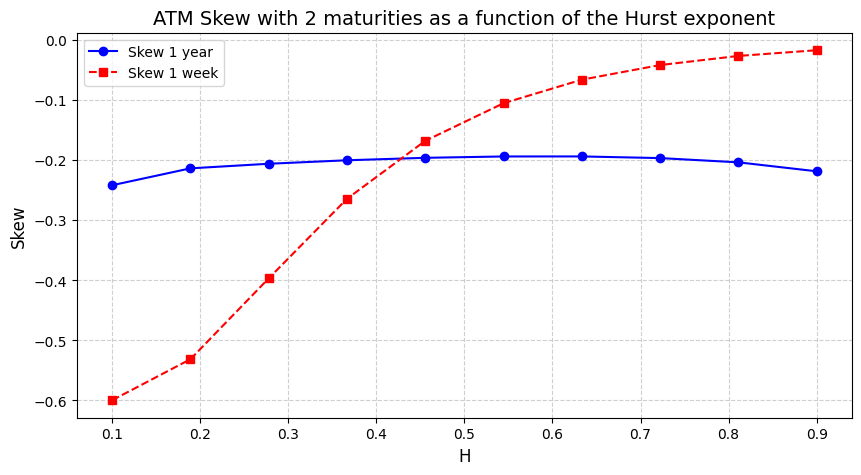

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(h_list, atm_skew_l_1y, label="Skew 1 year", linestyle="-", marker="o", color="blue")
plt.plot(h_list, atm_skew_l_1w, label="Skew 1 week", linestyle="--", marker="s", color="red")

plt.title("ATM Skew with 2 maturities as a function of the Hurst exponent", fontsize=14)
plt.xlabel("H", fontsize=12)
plt.ylabel("Skew", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

$\textbf{Question 2.4: Skew At-The-Money as a function of eps}$

In the previous section, we had at $\epsilon = 0$  that for H near 0.01, the 1-Year ATM Skewness would be quite large (around -0.25).

Now, by making $\epsilon$ vary, we are able to adjust down a bit more the value of the 1-Year Skewness to fit more closely to data.

Making $\epsilon$ vary on the other hand plays the same role as H previously in the sense that it allows us for a set $H$ to fit more closely the 1-Week Skewness observed on markets as the associated skewness takes a wide range of values.

In [41]:
eps_values = np.logspace(-3, 0, 10)
atm_skew_eps_l = [skew_atm(1, 0.01, e) for e in eps_values]
atm_skew_eps_w = [skew_atm(1/52, 0.01, e) for e in eps_values]

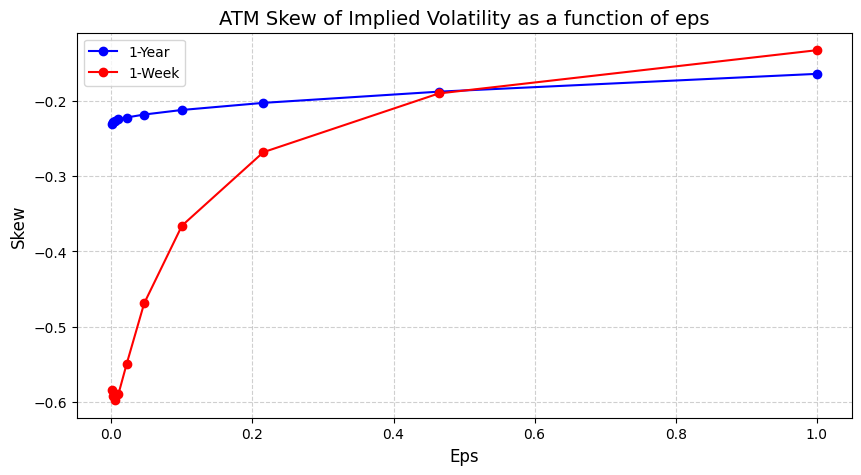

In [42]:
plt.figure(figsize=(10, 5))

plt.plot(eps_values, atm_skew_eps_l, label='1-Year', linestyle="-", marker="o", color="blue")
plt.plot(eps_values, atm_skew_eps_w, label='1-Week', linestyle="-", marker="o", color="red")
plt.title("ATM Skew of Implied Volatility as a function of eps", fontsize=14)
plt.xlabel("Eps", fontsize=12)
plt.ylabel("Skew", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

$\textbf{Question 2.5: Which market model?}$

The $\epsilon$-Rough-Heston model aligns more closely than the Heston model on the dynamics of the ATM Skewness: as a function of the maturity, Heston has a skew decaying exponentially while those $\epsilon$-$Rough-Heston have power-law decay when the maturity is not close to zero.

When $\epsilon$ changes, it allows us to fit the steepness of the skew curve near the time T=0 while the Hurst exponent allows us to control the Skewness on longer maturities.

As such, for short-term predictions, the Rough-Heston model with the 2 extra parameters (H and $\epsilon$) is better suited than Heston to fit the dynamics of the volatility surface.

On the other hand, the lack of an analytic formula for the characteristic function of the log-price in Rough-Heston makes it harder to produce precise outputs, especially for small H or T where things are more sensitive, as we have to approximate 2 integrals instead of just one in the Heston model pricing.